In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict
from plot import *
import seaborn as sns
import re

plt.style.use('seaborn-whitegrid')
logging.basicConfig(level=logging.CRITICAL)

/tmp/ipykernel_2051618/1111328684.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [27]:
def format_df_for_table(data_seed_aucs):
    # data_seed_aucs is a dict of structure data_seed_aucs[dataset][seed][algo] = auc
    # we need to format it into a df with columns: algo, dataset, value where value is the mean auc over seeds
    data = []
    for dataset, seed_aucs in data_seed_aucs.items():
        for seed, aucs in seed_aucs.items():
            for algo, auc in aucs.items():
                data.append({'dataset': dataset, 'seed': seed, 'algo': algo, 'auc': auc})
    df = pd.DataFrame(data)
    df = df.groupby(['dataset', 'algo']).agg({'auc': ['mean', 'std', 'sem']}).reset_index()
    df.columns = ['dataset', 'algo', 'mean', 'std', 'sem']
    return df

In [28]:
# choices = ["all_avg", "modular_ablation", "modular", "monolithic", "modmod_budget", "fedavg_monolithic_budget" "fedavg_modular_budget" "recv_modular" "recv_monolithic"
# "modmod_topology" "fedavg_modular_topology" "fedavg_monolithic_topology"]
what_to_plot = "modular"
# what_to_plot = "fedavg_monolithic_budget"
# what_to_plot = "fedavg_modular_topology"
# what_to_plot = "fedavg_monolithic_topology"
# what_to_plot = "modmod_topology"

In [29]:
datasets = ["mnist", "kmnist", "fashionmnist", "combined", "cifar100"]
# datasets = ["mnist", "kmnist", "fashionmnist"]
experiment_folder = "experiment_results"


use_contrastive = True

viz = False
seeds = [0, 1, 2, 3, 4, 5, 6, 7]
# seeds = [7]
tasks=None
agent_ids = None
ax=None
sync_bases = [True]
opt_with_randoms = [False]

metric='test_acc'



num_tryout_epochs = 20
max_num_modules_tryout = 3
num_shared_module_list = [1,2,3,4]

fedavg_comm_freq = [5, 10, 20, 50, 100]

recv_num_queries = [10, 20, 30]
recv_comm_freq = [9, 16, 50]

def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    if "sync_base" not in cfg.sharing_strategy:
        cfg.sharing_strategy['sync_base'] = False
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

# algos = ['modular']
if what_to_plot == "all_avg":
    algos = ['monolithic', 'modular']
    mode = "avg"
elif "modular" in what_to_plot or "modmod" in what_to_plot:
    algos = ['modular']
    mode = "current"
elif "monolithic" in what_to_plot:
    algos = ['monolithic']
    mode = "avg"
else:
    raise ValueError("Invalid choice")

use_contrastive_list = [False]


freeze_candidate_module = False
no_sparse_basis_ls = [True]

if what_to_plot == "modular_ablation":
    transfer_decoder_ls = [True, False]
    transfer_structure_ls = [True, False]
else:
    transfer_decoder_ls = [True]
    transfer_structure_ls = [True]

In [30]:
def get_save_dirs_modmod(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for sync_base in sync_bases:
        for opt_with_random in opt_with_randoms:
            for use_contrastive_opt in use_contrastive_list:
                for transfer_decoder in transfer_decoder_ls:
                    for transfer_structure in transfer_structure_ls:
                        for no_sparse_basis in no_sparse_basis_ls:
                            experiment_name = f"jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                            if dataset == "combined":
                                experiment_name = f"leep_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                            else:
                               experiment_name = f"jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                            if use_contrastive_opt:
                                name += "_contrastive"
                            name = f'jorge_setting_lowest_id_sync_{sync_base}_rand_{opt_with_random}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}'
                            save_dirs[name] = get_save_dir(experiment_folder, experiment_name,
                                                    dataset, "modular", num_trains_per_class, use_contrastive_opt, seed)

    return save_dirs



def get_save_dirs_modmod_budget(dataset, seed, budget_experiment_folder=None):
    if budget_experiment_folder is None:
        budget_experiment_folder = experiment_folder

    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for num_shared_module in num_shared_module_list:
        for sync_base in sync_bases:
            for opt_with_random in opt_with_randoms:
                for use_contrastive_opt in use_contrastive_list:
                    for transfer_decoder in transfer_decoder_ls:
                        for transfer_structure in transfer_structure_ls:
                            for no_sparse_basis in no_sparse_basis_ls:
                                if dataset == "combined":
                                    experiment_name = f"leep_tryout_epochs_{num_tryout_epochs}_max_modules_{max_num_modules_tryout}_num_shared_modules_{num_shared_module}_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                                else:
                                    experiment_name = f"tryout_epochs_{num_tryout_epochs}_max_modules_{max_num_modules_tryout}_num_shared_modules_{num_shared_module}_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                                name = f"tryout_epochs_{num_tryout_epochs}_max_modules_{max_num_modules_tryout}_num_shared_modules_{num_shared_module}_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}_frozen_{freeze_candidate_module}_transfer_decoder_{transfer_decoder}_transfer_structure_{transfer_structure}_no_sparse_basis_{no_sparse_basis}"
                                if use_contrastive_opt:
                                    name += "_contrastive"
                                save_dirs[name] = get_save_dir(budget_experiment_folder, experiment_name,
                                                        dataset, "modular", num_trains_per_class, use_contrastive_opt, seed)

    return save_dirs


def get_save_dirs_recv(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    experiment_name = f"jorge_setting_recv"
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            name = f"recv_{algo}"
            save_dirs[name] = get_save_dir(experiment_folder, experiment_name,
                                                dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs
    

def get_save_dirs_base(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            for no_sparse_basis in no_sparse_basis_ls:
                if no_sparse_basis:
                    base_experiment_name = "vanilla_jorge_setting_basis_no_sparse"
                else:
                    base_experiment_name = "vanilla_jorge_setting"
                name = f'{algo}_no_sparse_basis_{no_sparse_basis}'
                if use_contrastive_opt:
                    name += "_contrastive"
                save_dirs[name] = get_save_dir(experiment_folder, base_experiment_name,
                                        dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs

def get_save_dirs_fedavg(dataset, seed):
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            name = f'fedavg_{algo}'
            save_dirs[name] = get_save_dir(experiment_folder, "jorge_setting_fedavg",
                                            dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs


# def get_save_dirs_fedavg_budget(dataset, seed, budget_experiment_folder=None):
#     if budget_experiment_folder is None:
#         budget_experiment_folder = experiment_folder
#     save_dirs = {}
#     num_trains_per_class = 64 if dataset != "cifar100" else 256
#     for algo in algos:
#         for use_contrastive_opt in use_contrastive_list:
#             for freq in fedavg_comm_freq:
#                 name = f'fedavg_{algo}_f_{freq}'
#                 save_dirs[name] = get_save_dir(budget_experiment_folder, f"comm_freq_{freq}",
#                                                 dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
#     return save_dirs

# def get_save_dirs_recv_budget(dataset, seed, budget_experiment_folder=None):
#     if budget_experiment_folder is None:
#         budget_experiment_folder = experiment_folder
#     save_dirs = {}
#     num_trains_per_class = 64 if dataset != "cifar100" else 256
#     for algo in algos:
#         for use_contrastive_opt in use_contrastive_list:
#             for num_queries in recv_num_queries:
#                 for freq in recv_comm_freq:
#                     name = f'recv_{algo}_nq_{num_queries}_f_{freq}'
#                     # list all folder in budget_experiment_results that has the pattern "*comm_freq_{freq}_num_queries_{num_queries}*"
#                     for folder in os.listdir(budget_experiment_folder):
#                         if f"comm_freq_{freq}_num_queries_{num_queries}" in folder:
#                             save_dirs[name] = get_save_dir(budget_experiment_folder, folder,
#                                                 dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
#     return save_dirs



def get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder=None, patterns=None):
    if patterns is None:
        patterns = [r".*"]
    if root_experiment_folder is None:
        root_experiment_folder = experiment_folder
    save_dirs = {}
    num_trains_per_class = 64 if dataset != "cifar100" else 256
    for algo in algos:
        for use_contrastive_opt in use_contrastive_list:
            for folder in os.listdir(root_experiment_folder):
                if not os.path.isdir(os.path.join(root_experiment_folder, folder)) or not any([re.search(pattern, folder) for pattern in patterns]):
                    continue
                save_dirs[folder] = get_save_dir(root_experiment_folder, folder,
                                    dataset, algo, num_trains_per_class, use_contrastive_opt, seed)
    return save_dirs


def get_save_dirs(dataset, seed):
    save_dirs = {}

    if what_to_plot == "all_avg" or what_to_plot == "modular" or what_to_plot == "monolithic":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        if "modular" in algos:
            save_dirs.update(get_save_dirs_modmod(dataset, seed))
        save_dirs.update(get_save_dirs_fedavg(dataset, seed))
        save_dirs.update(get_save_dirs_recv(dataset, seed))
    elif what_to_plot == "modular_ablation":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_modmod(dataset, seed))
    elif what_to_plot == "modmod_budget":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_modmod_budget(dataset, seed, budget_experiment_folder="budget_experiment_results/modmod"))
    elif "fedavg" in what_to_plot and "topology" in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_fedavg(dataset, seed))
        # save_dirs.update(get_save_dirs_modmod_topology(dataset, seed, topology_experiment_results="new_topology_experiment_results/topology_experiment_results/jorge_setting_fedavg/comm_freq_5"))
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="new_topology_experiment_results/jorge_setting_fedavg/comm_freq_5",
         patterns=[r"disconnect", r"ring", r"server", r"tree"]))

    elif "fedavg" in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="budget_experiment_results/jorge_setting_fedavg"))
    elif "recv" in what_to_plot:
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="budget_experiment_results/jorge_setting_recv_variable_shared_memory_size"))
    elif what_to_plot == "modmod_topology":
        save_dirs.update(get_save_dirs_base(dataset, seed))
        save_dirs.update(get_save_dirs_modmod(dataset, seed))
        save_dirs.update(get_save_dirs_multiple_folders(dataset, seed, root_experiment_folder="new_topology_experiment_results/modmod",
        patterns=[r"disconnect", r"ring", r"server", r"tree"]))
    else:
        raise ValueError("Invalid choice")
    return save_dirs

In [31]:
remap_name = {
    
    
             "modular_no_sparse_basis_True" : "modular (baseline)",
              "monolithic_no_sparse_basis_True": "monolithic (baseline)",
            #  "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_False_no_sparse_basis_True": "transfer modules",
            #  "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure",
             "jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True": "modmod",

            #  "jorge_setting_lowest_id_sync_False_rand_False_transfer_decoder_False_transfer_structure_False_no_sparse_basis_True": "transfer modules (no sync)",
            # "jorge_setting_lowest_id_sync_False_rand_False_transfer_decoder_False_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure (no sync)",
            #  "jorge_setting_lowest_id_sync_False_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True": "transfer modules + structure + decoder (no sync)",

             "recv_modular": "Recv Modular",
             "fedavg_modular": "FedAvg Modular",
            #  "recv_monolithic": "Recv Monolithic",
            "fedavg_monolithic": "FedAvg Monolithic",

            # 'tryout_epochs_20_max_modules_3_num_shared_modules_1_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=1)',
            # 'tryout_epochs_20_max_modules_3_num_shared_modules_2_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=2)',
            # 'tryout_epochs_20_max_modules_3_num_shared_modules_3_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=3)',
            # 'tryout_epochs_20_max_modules_3_num_shared_modules_4_jorge_setting_lowest_task_id_wins_modmod_test_sync_base_True_opt_with_random_False_frozen_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True': 'modmod (k=4)',

            'comm_freq_5': 'FedAvg Monolithic (f=5)',
            'comm_freq_10': 'FedAvg Monolithic (f=10)',
            'comm_freq_20': 'FedAvg Monolithic (f=20)',
            'comm_freq_50': 'FedAvg Monolithic (f=50)',
            'comm_freq_100': 'FedAvg Monolithic (f=100)',

            # 'fedavg_modular_f_5': 'FedAvg Modular (f=5)',
            # 'fedavg_modular_f_10': 'FedAvg Modular (f=10)',
            # 'fedavg_modular_f_20': 'FedAvg Modular (f=20)',
            # 'fedavg_modular_f_50': 'FedAvg Modular (f=50)',
            # 'fedavg_modular_f_100': 'FedAvg Modular (f=100)',

            # 'recv_monolithic_nq_10_f_9': 'Recv Monolithic (nq=10, f=9)',
            # 'recv_monolithic_nq_10_f_16': 'Recv Monolithic (nq=10, f=16)',
            # 'recv_monolithic_nq_10_f_50': 'Recv Monolithic (nq=10, f=50)',
            # 'recv_monolithic_nq_20_f_9': 'Recv Monolithic (nq=20, f=9)',
            # 'recv_monolithic_nq_20_f_16': 'Recv Monolithic (nq=20, f=16)',
            # 'recv_monolithic_nq_20_f_50': 'Recv Monolithic (nq=20, f=50)',
            # 'recv_monolithic_nq_30_f_9': 'Recv Monolithic (nq=30, f=9)',
            # 'recv_monolithic_nq_30_f_16': 'Recv Monolithic (nq=30, f=16)',
            # 'recv_monolithic_nq_30_f_50': 'Recv Monolithic (nq=30, f=50)',

            # 'recv_modular_nq_10_f_9': 'Recv Modular (nq=10, f=9)',
            # 'recv_modular_nq_10_f_16': 'Recv Modular (nq=10, f=16)',
            # 'recv_modular_nq_10_f_50': 'Recv Modular (nq=10, f=50)',
            # 'recv_modular_nq_20_f_9': 'Recv Modular (nq=20, f=9)',
            # 'recv_modular_nq_20_f_16': 'Recv Modular (nq=20, f=16)',
            # 'recv_modular_nq_20_f_50': 'Recv Modular (nq=20, f=50)',
            # 'recv_modular_nq_30_f_9': 'Recv Modular (nq=30, f=9)',
            # 'recv_modular_nq_30_f_16': 'Recv Modular (nq=30, f=16)',
            # 'recv_modular_nq_30_f_50': 'Recv Modular (nq=30, f=50)',

            'topology_server_edge_drop_0.0': 'server',
            'topology_tree_edge_drop_0.0': 'tree',
            'topology_ring_edge_drop_0.0': 'ring',

            # 'topology_random_edge_drop_0.7': 'random (p=0.7)',
            # 'topology_random_edge_drop_0.5': 'random (p=0.5)',
            # 'topology_random_edge_drop_0.25': 'random (p=0.25)',
            # 'topology_random_edge_drop_0.9': 'random (p=0.9)',

            # 'topology_random_disconnect_edge_drop_0.25': 'random disconnect (p=0.25)',
            # 'topology_random_disconnect_edge_drop_0.5': 'random disconnect (p=0.5)',
            # 'topology_random_disconnect_edge_drop_0.7': 'random disconnect (p=0.7)',
            # 'topology_random_disconnect_edge_drop_0.9': 'random disconnect (p=0.9)',

             'topology_random_disconnect_edge_drop_0.25': 'random (p=0.25)',
            'topology_random_disconnect_edge_drop_0.5': 'random (p=0.5)',
            'topology_random_disconnect_edge_drop_0.7': 'random (p=0.7)',
            'topology_random_disconnect_edge_drop_0.9': 'random (p=0.9)',

             }

num_colors = len(remap_name)
# color_map = plt.cm.get_cmap('tab20b', num_colors)
color_map = plt.cm.get_cmap('tab10', num_colors)
colors = color_map(range(num_colors))

# colormap = {
#     'modular (baseline)': colors[0],
#     "monolithic (baseline)": colors[1],
#     'modmod': colors[2],
#     'Recv Modular': colors[3],
#     'FedAvg Modular': colors[4],
#     'Recv Monolithic': colors[5],
#     'FedAvg Monolithic': colors[6],
#     'transfer modules': colors[7],
#     'transfer modules + structure': colors[8],
#     'modmod (k=1)': colors[9],
#     'modmod (k=2)': colors[10],
#     'modmod (k=3)': colors[11],
#     'modmod (k=4)': colors[12],


# }

colormap = {k: colors[i] for i, k in enumerate(remap_name.values())}


/tmp/ipykernel_2051618/3874709937.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab10', num_colors)


In [32]:
dataset_seed_aucs, dataset_agg_dfs = load_data(get_save_dirs, seeds, datasets, modify_cfg, viz, tasks, agent_ids, ax, mode=mode,
                                               metric=metric, strict=True)

In [33]:
# HACK: for fedavg just throw away the epoch 5 since it's not recorded in the later code for some reasons
if what_to_plot == "fedavg_monolithic_topology":
    dataset_agg_dfs = {k: df[df['epoch'] != 5] for k, df in dataset_agg_dfs.items()}

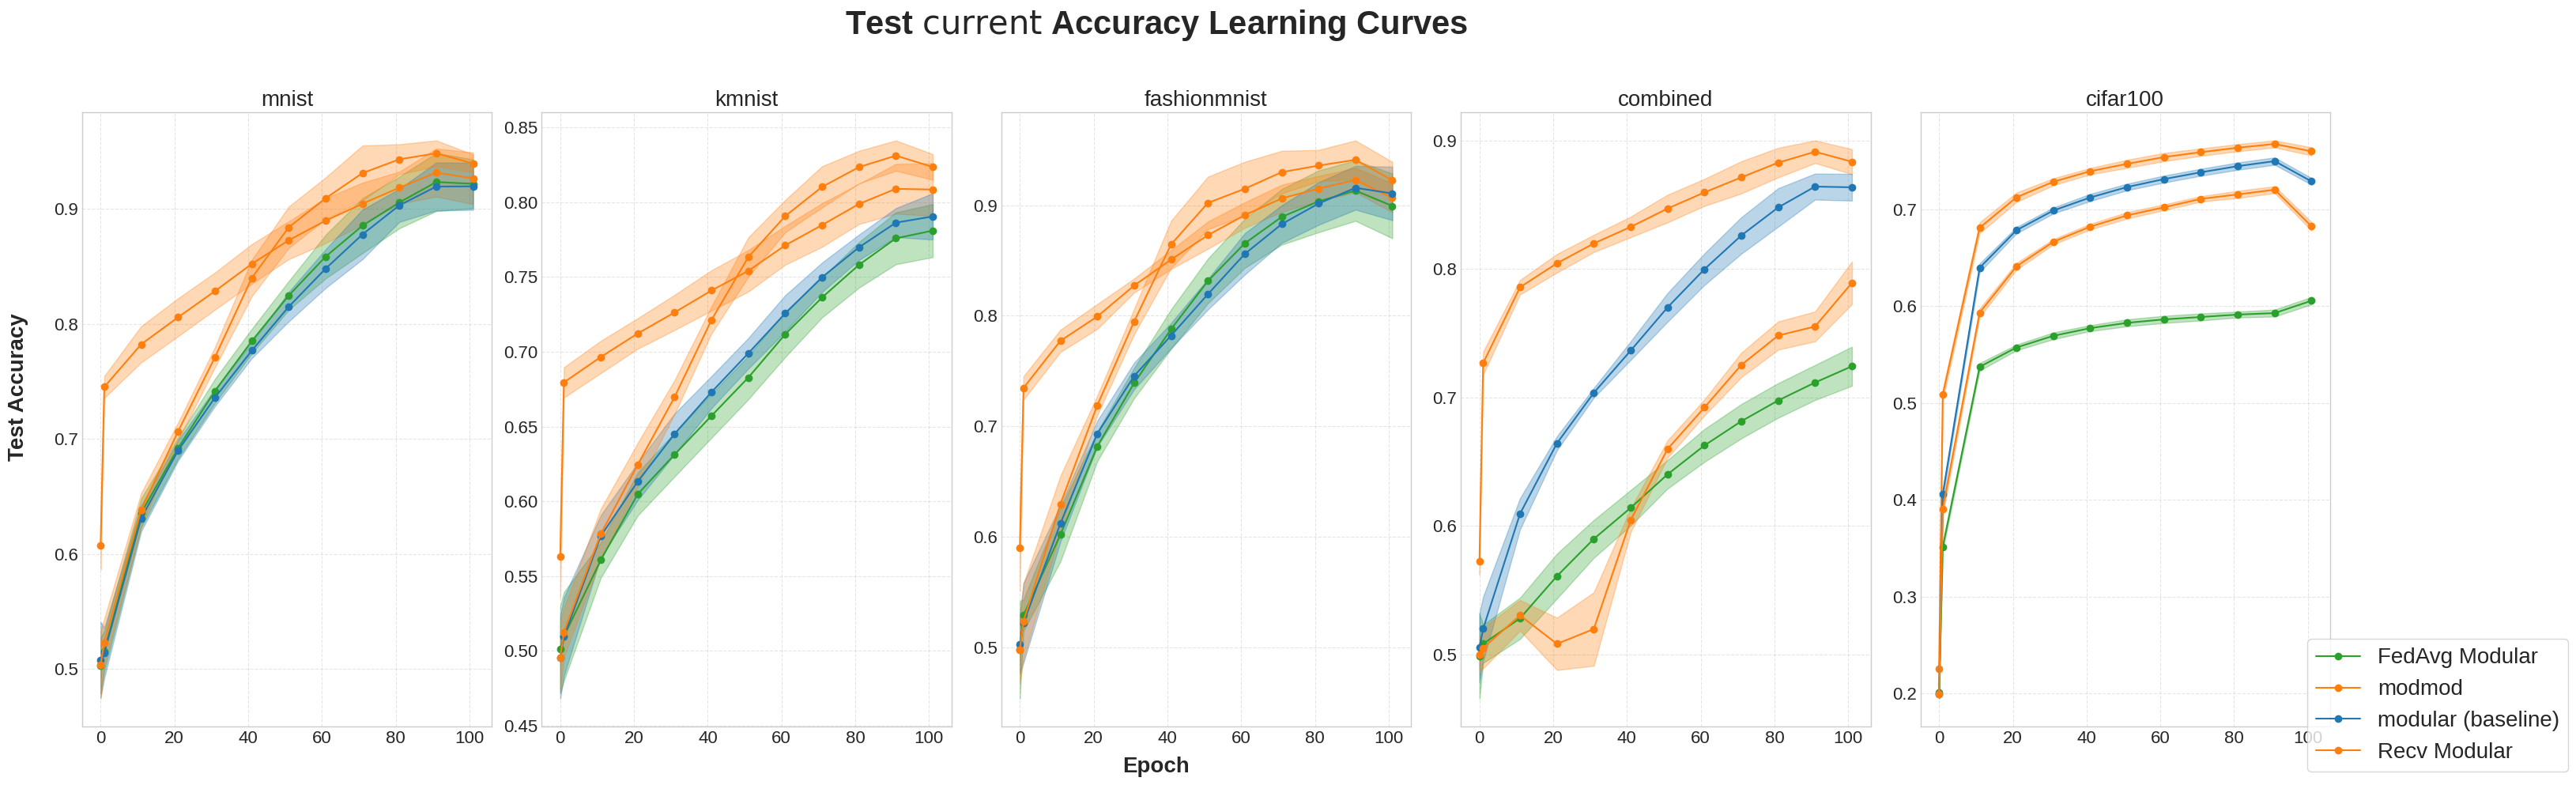

In [34]:
plot_learning_curve_dataset(dataset_agg_dfs, remap_name=remap_name, colormap=colormap,
                            mode=mode, save_fig_path=f'Figures/{what_to_plot}_lc.pdf',
                            error_type='std')

In [35]:
# custom_algo_order = ['modmod',
#  'random (p=0.25)',
#  'random (p=0.5)',
#  'random (p=0.7)',
#  'random (p=0.9)',
#  'modular (baseline)',
#  'server',
#  'ring',
#  'tree']

In [36]:
# colormap_alternative_0 = {
#     'modmod': '#1f77b4',  # Blue, p=0.0
#     'random (p=0.25)': '#4e90a4',  # Transition color
#     'random (p=0.5)': '#7daa94',  # Transition color
#     'random (p=0.7)': '#acC484',  # Transition color
#     'random (p=0.9)': '#dbcE74',  # Transition color
#     'modular (baseline)': '#ff7f0e',  # Orange, p=1.0
#     'server': '#2ca02c',  # Green, distinct topology
#     'ring': '#d62728',  # Red, distinct topology
#     'tree': '#9467bd'   # Purple, distinct topology
# }

# colormap_alternative_1 = {
#     'modmod': '#17becf',  # Teal
#     'random (p=0.25)': '#9edae5',  # Light teal
#     'random (p=0.5)': '#b5cf6b',  # Light green
#     'random (p=0.7)': '#dbdb8d',  # Olive green
#     'random (p=0.9)': '#f7b6d2',  # Pink
#     'modular (baseline)': '#e377c2',  # Vibrant pink
#     'server': '#1f77b4',  # Blue
#     'ring': '#ff7f0e',  # Orange
#     'tree': '#2ca02c',  # Green
# }


# colormap_alternative_2 = {
#     'modmod': '#1f77b4',  # Deep ocean blue
#     'random (p=0.25)': '#2ca02c',  # Seafoam green
#     'random (p=0.5)': '#9ecae1',  # Sky blue
#     'random (p=0.7)': '#fdbe85',  # Peach
#     'random (p=0.9)': '#fd8d3c',  # Sunset orange
#     'modular (baseline)': '#d62728',  # Deep sunset red
#     'server': '#e7ba52',  # Gold
#     'ring': '#9467bd',  # Purple
#     'tree': '#17becf',  # Cyan
# }


# colormap_alternative_3 = {
#     'modmod': '#2ca02c',  # Forest green
#     'random (p=0.25)': '#637939',  # Olive green
#     'random (p=0.5)': '#8ca252',  # Leaf green
#     'random (p=0.7)': '#b5cf6b',  # Light green
#     'random (p=0.9)': '#e7ba52',  # Yellow gold
#     'modular (baseline)': '#ff7f0e',  # Flame orange
#     'server': '#17becf',  # Cyan
#     'ring': '#9467bd',  # Purple
#     'tree': '#d62728',  # Red
# }


modular_no_sparse_basis_True: Average AUC = 79.66, STD = 2.24, STDERR = 0.79
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True: Average AUC = 86.91, STD = 1.23, STDERR = 0.43
fedavg_modular: Average AUC = 80.22, STD = 2.20, STDERR = 0.78
recv_modular: Average AUC = 83.56, STD = 1.42, STDERR = 0.50
modular_no_sparse_basis_True: Average AUC = 69.39, STD = 1.41, STDERR = 0.50
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True: Average AUC = 76.00, STD = 1.38, STDERR = 0.49
fedavg_modular: Average AUC = 68.14, STD = 2.16, STDERR = 0.76
recv_modular: Average AUC = 73.31, STD = 1.19, STDERR = 0.42
modular_no_sparse_basis_True: Average AUC = 79.76, STD = 1.78, STDERR = 0.63
jorge_setting_lowest_id_sync_True_rand_False_transfer_decoder_True_transfer_structure_True_no_sparse_basis_True: Average AUC = 86.50, STD = 0.97, STDERR = 0.34
fedavg_modular: Average AUC = 79.79, STD 

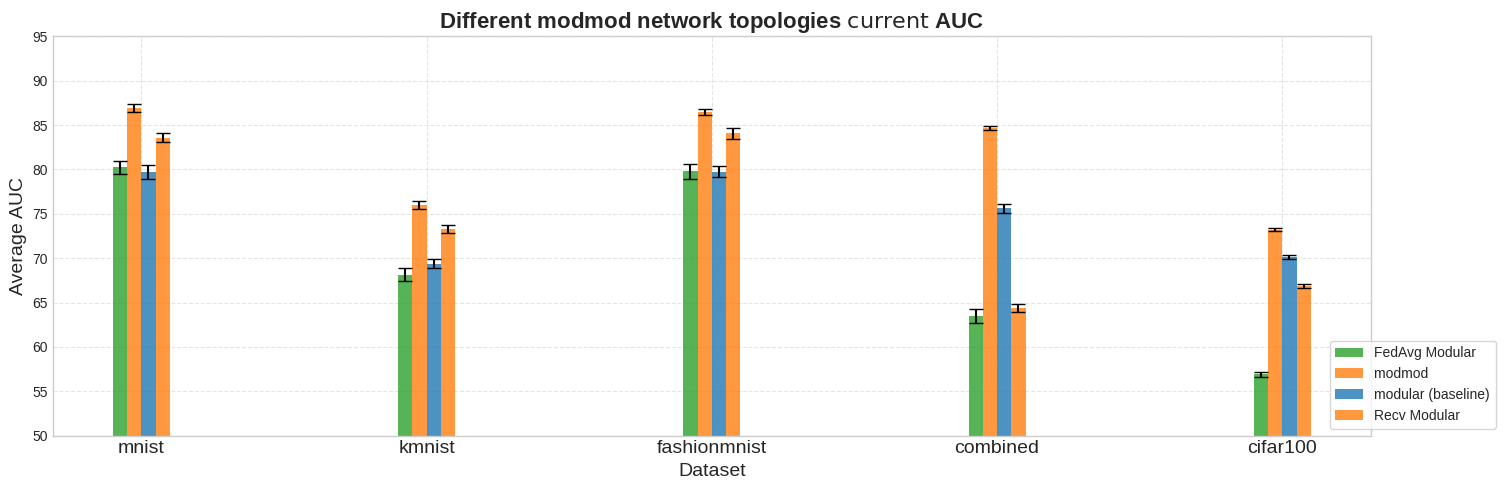

In [37]:
# plot_auc_combined(dataset_seed_aucs, remap_name=remap_name, colormap=colormap_alternative_0, mode=mode, save_fig_path=f'Figures/{what_to_plot}_auc.pdf',
#                   bar_width=0.05,
#                   custom_algo_order=custom_algo_order,
#                   plot_prefix_name="Different modmod network topologies ",
#                   error_type="sem")

plot_auc_combined(dataset_seed_aucs, remap_name=remap_name, colormap=colormap, mode=mode, save_fig_path=f'Figures/{what_to_plot}_auc.pdf',
                  bar_width=0.05,
                  plot_prefix_name="Different modmod network topologies ",
                  error_type="sem")

In [38]:
table_df = format_df_for_table(dataset_seed_aucs)
make_table_v2(table_df, error_type='sem', remap_name=remap_name)

Algorithm,cifar100,combined,fashionmnist,kmnist,mnist
FedAvg Modular,56.88550 +/- 0.29,63.52175 +/- 0.86,79.79366 +/- 0.88,68.14459 +/- 0.82,80.22326 +/- 0.83
modmod,73.22560 +/- 0.17,84.64696 +/- 0.23,86.49750 +/- 0.37,75.99672 +/- 0.52,86.90714 +/- 0.46
modular (baseline),70.12575 +/- 0.23,75.64345 +/- 0.54,79.76240 +/- 0.67,69.38793 +/- 0.53,79.65826 +/- 0.85
Recv Modular,66.90512 +/- 0.24,64.39969 +/- 0.51,84.06194 +/- 0.70,73.30765 +/- 0.45,83.55555 +/- 0.54
